In [16]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
from scipy.integrate import simpson
from scipy.interpolate import griddata

## Define the loader method

In [17]:
def load_plumed(fname, line_lim=np.Inf):
    data = {}
    with open(fname, 'r') as f:
        fields = f.readline()[:-1].split(" ")[2:] # last char is '/n' and the first two are '#!' and 'FIELDS'
        for field in fields: # add fields to the colvars dict
            data[field] = []
        line_cnt = 0
        while (line_cnt<line_lim): # read up to LINE_LIM lines
            line = f.readline()
            if not line:
                break
            if line[0] == "#": # Don't read comments
                continue
            
            line_list = line.split()
            try: # account for incomplete files (useful when the sims is still running)
                for i, field in enumerate(fields):
                    data[field].append(float(line_list[i]))
            except:
                break
            finally:
                line_cnt += 1
    try:
        print("Read {} lines with {} headings. Last timestamp: {}".format(line_cnt, len(fields), data['time'][-1]))
    except:
        print("Read {} lines with {} headings. No timestamps available.".format(line_cnt, len(fields)))
    return data

In [18]:
LINE_LIM = np.Inf
KbT = 300 * 8.314 # J/mol
d_cutoff = 2.5

## Read the COLVAR file

In [19]:
colvars = load_plumed("COLVAR", LINE_LIM)
colvars = pd.DataFrame(colvars)
colvars['weights'] = np.exp(colvars['pb.bias']*1000/KbT)
init_time = 100 #ns
colvars = colvars.iloc[init_time * 10000 // 2:]
colvars.head(5)

Read 3000001 lines with 8 headings. Last timestamp: 600000.0


,time,dcom,ang,angorig,dc,pb.bias,uwall.bias,lwall.bias,weights
500000,100000.0,0.615353,-2.998520,2.998520,-1.0,423.180112,0.0,0.0,4.840206e+73
500001,100000.2,0.605720,-2.971502,2.971502,-1.0,423.047896,0.0,0.0,4.590312e+73
500002,100000.4,0.637018,-2.928496,2.928496,-1.0,423.428117,0.0,0.0,5.346221e+73
500003,100000.6,0.611281,-2.891058,2.891058,-1.0,423.210595,0.0,0.0,4.899724e+73
500004,100000.8,0.592120,-2.849354,2.849354,-1.0,422.832791,0.0,0.0,4.211024e+73


## Calculate and plot Free Energy

In [20]:
def PMF(x, weights, ax, S_cor = False, normalize = True, bins=100):
    counts, bins = np.histogram(x, bins=bins, weights=weights)
    bin_centers = (bins[1:] + bins[:-1])/2
    free_energy = -KbT*np.log(counts)/1000 #kJ/mol
    if S_cor:
        free_energy += 2*KbT*np.log(bin_centers)/1000
    if normalize:
        free_energy -= free_energy.min() # normalize to minima
    ax.plot(bin_centers, free_energy, lw=2, c='r')
    return bin_centers, free_energy, ax


def FES(x, y, weights, ax, x_S_cor = False, **kwargs):
    # calculate histogram
    counts, binsx, binsy = np.histogram2d(x, y, bins=50, weights=weights)
    counts[counts==0] = np.nan # discard empty bins
    free_energy = -KbT*np.log(counts)/1000 #kJ/mol
    free_energy = free_energy.T[::-1,:] # swap x and y axes, and reverse the order of the x axis.

    # xticks
    xs = np.round((binsx[1:] + binsx[:-1])/2, 2)
    step_x = int(xs.shape[0] / (8 - 1))
    x_positions = np.arange(0,xs.shape[0],step_x)
    x_labels = xs[::step_x]

    # yticks
    ys = np.round((binsy[1:] + binsy[:-1])/2, 2)
    step_y = int(ys.shape[0] / (8 - 1))
    y_positions = np.arange(0,ys.shape[0],step_y)
    y_labels = ys[::step_y]
    y_labels = y_labels[::-1]
    #plot
    if x_S_cor:
        free_energy += np.tile(2*KbT*np.log(xs)/1000, (free_energy.shape[0], 1))

    fe_ma = ma.masked_invalid(free_energy) # mask nan values
    free_energy -= fe_ma.min() # normalize to minima
    cm = ax.imshow(free_energy, cmap="Greens_r", **kwargs)
    cbar = plt.colorbar(cm)
    cbar.ax.set_title(r"FE kJ/mol$^{-1}$")
    ax.set_xticks(x_positions, x_labels)
    ax.set_yticks(y_positions, y_labels)
    plt.tight_layout()
    return ax


def block_anal(x, weights, ax, S_cor=False, folds=5, nbins=100):
    _, bins = np.histogram(x, bins=nbins)
    xs = (bins[1:] + bins[:-1])/2
    block_size = len(x)//folds
    data = pd.DataFrame()
    data['bin_center'] = xs
    for fold in range(folds):
        counts, _ = np.histogram(x[block_size*fold:(fold+1)*block_size], bins=bins, weights=weights[block_size*fold:(fold+1)*block_size])
        Fs = -KbT*np.log(counts)/1000 #kJ/mol
        if S_cor:
            Fs += 2*KbT*np.log(xs)/1000
        data[f"f_{fold}"] = Fs
    
    data_s = pd.DataFrame()
    data_s['bin_center'] = data['bin_center']
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    for fold in range(folds):
        data_s[f"f_{fold}"] = data[f"f_{fold}"] - data[f"f_{fold}"].mean()
        #ax.plot(xs, data_s[f"f_{fold}"], lw=1)

    data_s_temp = data_s.replace([np.inf, -np.inf], np.nan)
    data_s['std'] = data_s_temp.apply(np.std, axis=1)
    data_s['ste'] = 1/np.sqrt(folds)*data_s['std']

    counts, _ = np.histogram(x, bins=bins, weights=weights)
    Fs = -KbT*np.log(counts)/1000 #kJ/mol
    if S_cor:
        Fs += 2*KbT*np.log(xs)/1000
    
    data_s["f_all"] = Fs
    data_s["f_all"] = data_s["f_all"] - data_s["f_all"].mean()

    ax.plot(xs, data_s["f_all"], lw=2, c='k')
    ax.fill_between(data.bin_center, data_s["f_all"]-data_s['ste'], data_s["f_all"]+data_s['ste'], color='grey', alpha=0.5)
    return data_s, ax

def block_anal_2d(x, y, weights, folds=5, nbins=100):
    # calculate histogram for all data to get bins
    counts_all, binsx, binsy = np.histogram2d(x, y, bins=nbins, weights=weights)
    # calculate bin centers
    xs = np.round((binsx[1:] + binsx[:-1])/2, 2)
    ys = np.round((binsy[1:] + binsy[:-1])/2, 2)
    # find block sizes
    block_size = len(x)//folds
    # data frame to store the blocks
    data = pd.DataFrame()
    xs_unrolled = []
    ys_unrolled = []
    for i in xs:
        for j in ys:
            xs_unrolled.append(i)
            ys_unrolled.append(j)
    
    data['x'] = xs_unrolled
    data['y'] = ys_unrolled

    # calculate free energy for each fold
    for fold in range(folds):
        x_fold = x[block_size*fold:(fold+1)*block_size]
        y_fold = y[block_size*fold:(fold+1)*block_size]
        weights_fold = weights[block_size*fold:(fold+1)*block_size]
        counts, _, _ = np.histogram2d(x_fold, y_fold, bins=[binsx, binsy], weights=weights_fold)
        counts[counts==0] = np.nan # discard empty bins
        free_energy = -KbT*np.log(counts)/1000 #kJ/mol
        free_energy_unrolled = []
        for i in range(len(xs)):
            for j in range(len(ys)):
                 free_energy_unrolled.append(free_energy[i, j])
        data[f"f_{fold}"] = free_energy_unrolled
        # Entropy correction along x axis
        data[f"f_{fold}"] += 2*KbT*np.log(data.x)/1000
    
    # de-mean the folds for curve matching
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    for fold in range(folds):
        data[f"f_{fold}"] = data[f"f_{fold}"] - data[f"f_{fold}"].mean()
    
    # calcualte standard deviation and standard error
    data['std'] = data[[f"f_{fold}" for fold in range(folds)]].apply(np.std, axis=1)
    data['ste'] = 1/np.sqrt(folds)*data['std']

    # calculate free energy from all data
    counts_all[counts_all==0] = np.nan # discard empty bins
    free_energy = -KbT*np.log(counts_all)/1000 #kJ/mol
    free_energy_unrolled = []
    for i in range(len(xs)):
            for j in range(len(ys)):
                free_energy_unrolled.append(free_energy[i, j])
    data["f_all"] = free_energy_unrolled
    # Entropy correction along x axis
    data["f_all"] += 2*KbT*np.log(data.x)/1000
    data["f_all"] = data["f_all"] - data["f_all"].mean()

    data["f_avg"] = data[[f"f_{fold}" for fold in range(folds)]].apply(np.mean, axis=1)

    return data

def _find_flat(y, x, max_df = 5):
        dx = np.gradient(y, x)
        for ind in range(len(dx)):
            if np.mean(np.abs(dx[ind:])) < max_df and (ind < len(dx) - 10):
                return ind
        raise ValueError("No stretch of the free energy profile is flat enough. Maybe PBMETAD is not converged?")

def FE_plot(X, Y, weights, ax, fig):
    # calculate histogram
    counts, binsx, binsy = np.histogram2d(X, Y, bins=50, weights=weights)
    counts[counts==0] = np.nan # discard empty bins
    free_energy = -KbT*np.log(counts)/1000 #kJ/mol

    xs = np.round((binsx[1:] + binsx[:-1])/2, 2)
    ys = np.round((binsy[1:] + binsy[:-1])/2, 2)

    dict_data = {"X":[], "Y":[], "Free":[]}
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            dict_data["X"].append(x)
            dict_data["Y"].append(y)
            dict_data["Free"].append(free_energy[i, j])
    
    FE_data = pd.DataFrame(dict_data)
    FE_data.Free += KbT*2*np.log(FE_data.X)/1000
    FE_data.Free -= FE_data.Free.min()
    FE_data.dropna(inplace=True)

    X_plot = np.linspace(FE_data.X.min(), FE_data.X.max(), 100)
    Y_plot = np.linspace(FE_data.Y.min(), FE_data.Y.max(), 100)
    Z_plot = griddata((FE_data.X, FE_data.Y), FE_data.Free, (X_plot[None,:], Y_plot[:,None]), method='cubic')
    cb_min = (np.nanmin(Z_plot)//10 - 1)*10
    cb_max = (np.nanmax(Z_plot)//10 + 1)*10
    CS = ax.contourf(X_plot, Y_plot, Z_plot, 30, cmap=plt.cm.Blues_r, extend='max', vmax=cb_max, vmin=cb_min)
    return ax, CS

def FE_plot_nocalc(X, Y, F, ax, cb_min=None, cb_max=None, method='cubic', cmap=None):
    data = pd.DataFrame({"X": X, "Y": Y, "F": F})
    data.dropna(inplace=True)
    X_plot = np.linspace(data.X.min(), data.X.max(), 100)
    Y_plot = np.linspace(data.Y.min(), data.Y.max(), 100)
    Z_plot = griddata((data.X, data.Y), data.F, (X_plot[None,:], Y_plot[:,None]), method=method)
    if cb_min is None:
        cb_min = (np.nanmin(Z_plot)//10 - 1)*10
    if cb_max is None:
        cb_max = (np.nanmax(Z_plot)//10 + 1)*10
    if cmap is None:
        cmap=plt.cm.Blues_r
    CS = ax.contourf(X_plot, Y_plot, Z_plot, 30, cmap=cmap, extend='max', vmax=cb_max, vmin=cb_min)
    return ax, CS

def calc_region_int(data):
    """
    data = DataFrame with columns x(dcom), y(angle), F(free energy)
    """
    data["exp"] = np.exp(-data.F*1000/KbT)
    Y_integrand = {"X": [], "exp":[]}
    # integrate over Y
    for x in data.x.unique():
        FE_this_x = data[data.x == x]
        Y_integrand["X"].append(x)
        Y_integrand["exp"].append(simpson(y=FE_this_x.exp.to_numpy(), x=FE_this_x.y.to_numpy()))
    
    Y_integrand_pd = pd.DataFrame(Y_integrand)
    # integrate over X
    integrand = simpson(y=Y_integrand_pd.exp.to_numpy(), x=Y_integrand_pd.X.to_numpy())
    
    return -KbT*np.log(integrand)/1000
    

In [21]:
def calc_FE_2d(X: np.ndarray, Y: np.ndarray, weights: np.ndarray, rbase: dict, pbase: dict) -> float:
    """
    2D integration of the FE surface to calculate FE difference between a reactanct and a product basin.

    args:
        X (np.ndarray): numpy array of colvar 1
        Y (np.ndarray): numpy array of colvar 2
        weights (np.ndarray): numpy array of weights from reweighting run
        rbase (dict): dict defining reactant basin ["X": (x_min, x_max), "Y": (y_min, y_max)]
        pbase (dict): dict defining product basin ["X": (x_min, x_max), "Y": (y_min, y_max)]
    
    returns:
        dFE: Free energy difference between reactant and product
    """
    counts, binsx, binsy = np.histogram2d(X, Y, bins=50, weights=weights)
    counts[counts==0] = np.nan # discard empty bins
    free_energy = -KbT*np.log(counts)/1000 #kJ/mol
    xs = np.round((binsx[1:] + binsx[:-1])/2, 2)
    ys = np.round((binsy[1:] + binsy[:-1])/2, 2)

    dict_data = {"X":[], "Y":[], "Free":[]}
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            dict_data["X"].append(x)
            dict_data["Y"].append(y)
            dict_data["Free"].append(free_energy[i, j])
    
    FE_data = pd.DataFrame(dict_data)
    FE_data.Free += KbT*2*np.log(FE_data.X)/1000
    FE_data.fillna(np.inf, inplace=True)
    FE_data["exp"] = np.exp(-FE_data.Free*1000/KbT)

    Y_integrand = {"r":{"X": [], "exp":[]}, "p":{"X": [], "exp":[]}}
    # integrate over Y
    for x in FE_data.X.unique():
        FE_this_x = FE_data[FE_data.X == x]
        # reactant
        Y_integrand["r"]["X"].append(x)
        FE_this_x_r = FE_this_x[(FE_this_x.Y>rbase["Y"][0]) & (FE_this_x.Y<rbase["Y"][1])]
        Y_integrand["r"]["exp"].append(simpson(y=FE_this_x_r.exp.to_numpy(), x=FE_this_x_r.Y.to_numpy()))
        # product
        Y_integrand["p"]["X"].append(x)
        FE_this_x_p = FE_this_x[(FE_this_x.Y>pbase["Y"][0]) & (FE_this_x.Y<pbase["Y"][1])]
        Y_integrand["p"]["exp"].append(simpson(y=FE_this_x_p.exp.to_numpy(), x=FE_this_x_p.Y.to_numpy()))
    
    Y_integrand_r = pd.DataFrame(Y_integrand["r"])
    Y_integrand_r = Y_integrand_r[(Y_integrand_r.X>rbase["X"][0]) & (Y_integrand_r.X<rbase["X"][1])]
    Y_integrand_p = pd.DataFrame(Y_integrand["p"])
    Y_integrand_p = Y_integrand_p[(Y_integrand_p.X>pbase["X"][0]) & (Y_integrand_p.X<pbase["X"][1])]
    # integrate over X
    # reactant
    r_integrand = simpson(y=Y_integrand_r.exp.to_numpy(), x=Y_integrand_r.X.to_numpy())
    # product
    p_integrand = simpson(y=Y_integrand_p.exp.to_numpy(), x=Y_integrand_p.X.to_numpy())
    
    return -KbT*np.log(p_integrand/r_integrand)/1000

def calc_FE_3d(data, weights: np.ndarray, rbase: dict, pbase: dict) -> float:

    counts, bins = np.histogramdd(data, weights=weights, bins=50)
    counts[counts==0] = np.nan # discard empty bins
    free_energy = -KbT*np.log(counts)/1000 #kJ/mol
    bin_centers = {}
    for i, dim in enumerate(bins):
        bin_centers[f"dim{i}"] = np.round((dim[1:] + dim[:-1])/2, 2)
    
    dict_data = {"X":[], "Y":[], "Z":[], "Free":[]}
    for i, x in enumerate(bin_centers["dim0"]):
        for j, y in enumerate(bin_centers["dim1"]):
            for k, z in enumerate(bin_centers["dim2"]):
                dict_data["X"].append(x)
                dict_data["Y"].append(y)
                dict_data["Z"].append(z)
                dict_data["Free"].append(free_energy[i, j, k])
    
    FE_data = pd.DataFrame(dict_data)
    FE_data.Free += KbT*2*np.log(FE_data.X)/1000
    FE_data.fillna(np.inf, inplace=True)
    FE_data["exp"] = np.exp(-FE_data.Free*1000/KbT)

    Z_integrand = {"r":{"X": [], "Y": [], "exp":[]}, "p":{"X": [], "Y":[], "exp":[]}}
    # integrate over Z
    for y in FE_data.Y.unique():
        FE_this_y = FE_data[FE_data.Y == y]
        for x in FE_data.X.unique():
            FE_this_y_x = FE_this_y[FE_this_y.X == x]
            # reactant
            Z_integrand["r"]["X"].append(x)
            Z_integrand["r"]["Y"].append(y)
            FE_this_y_x_r = FE_this_y_x[(FE_this_y_x.Z>rbase["Z"][0]) & (FE_this_y_x.Z<rbase["Z"][1])]
            Z_integrand["r"]["exp"].append(simpson(y=FE_this_y_x_r.exp.to_numpy(), x=FE_this_y_x_r.Z.to_numpy()))
            # product
            Z_integrand["p"]["X"].append(x)
            Z_integrand["p"]["Y"].append(y)
            FE_this_y_x_p = FE_this_y_x[(FE_this_y_x.Z>pbase["Z"][0]) & (FE_this_y_x.Z<pbase["Z"][1])]
            Z_integrand["p"]["exp"].append(simpson(y=FE_this_y_x_p.exp.to_numpy(), x=FE_this_y_x_p.Z.to_numpy()))
    
    # integrate over Y
    Y_integrand = {"r":{"X": [], "exp":[]}, "p":{"X": [], "exp":[]}}
    Z_integrand_r = pd.DataFrame(Z_integrand["r"])
    for x in FE_data.X.unique():
        FE_this_x = Z_integrand_r[Z_integrand_r.X == x]
        # reactant
        Y_integrand["r"]["X"].append(x)
        FE_this_x_r = FE_this_x[(FE_this_x.Y>rbase["Y"][0]) & (FE_this_x.Y<rbase["Y"][1])]
        Y_integrand["r"]["exp"].append(simpson(y=FE_this_x_r.exp.to_numpy(), x=FE_this_x_r.Y.to_numpy()))
        # product
        Y_integrand["p"]["X"].append(x)
        FE_this_x_p = FE_this_x[(FE_this_x.Y>pbase["Y"][0]) & (FE_this_x.Y<pbase["Y"][1])]
        Y_integrand["p"]["exp"].append(simpson(y=FE_this_x_p.exp.to_numpy(), x=FE_this_x_p.Y.to_numpy()))
    
    Z_integrand_p = pd.DataFrame(Z_integrand["p"])
    for x in FE_data.X.unique():
        FE_this_x = Z_integrand_p[Z_integrand_p.X == x]
        # reactant
        Y_integrand["r"]["X"].append(x)
        FE_this_x_r = FE_this_x[(FE_this_x.Y>rbase["Y"][0]) & (FE_this_x.Y<rbase["Y"][1])]
        Y_integrand["r"]["exp"].append(simpson(y=FE_this_x_r.exp.to_numpy(), x=FE_this_x_r.Y.to_numpy()))
        # product
        Y_integrand["p"]["X"].append(x)
        FE_this_x_p = FE_this_x[(FE_this_x.Y>pbase["Y"][0]) & (FE_this_x.Y<pbase["Y"][1])]
        Y_integrand["p"]["exp"].append(simpson(y=FE_this_x_p.exp.to_numpy(), x=FE_this_x_p.Y.to_numpy()))
    
    Y_integrand_r = pd.DataFrame(Y_integrand["r"])
    Y_integrand_r = Y_integrand_r[(Y_integrand_r.X>rbase["X"][0]) & (Y_integrand_r.X<rbase["X"][1])]
    Y_integrand_p = pd.DataFrame(Y_integrand["p"])
    Y_integrand_p = Y_integrand_p[(Y_integrand_p.X>pbase["X"][0]) & (Y_integrand_p.X<pbase["X"][1])]

    # integrate over X
    # reactant
    r_integrand = simpson(y=Y_integrand_r.exp.to_numpy(), x=Y_integrand_r.X.to_numpy())
    # product
    p_integrand = simpson(y=Y_integrand_p.exp.to_numpy(), x=Y_integrand_p.X.to_numpy())
    

    return -KbT*np.log(p_integrand/r_integrand)/1000

def calc_region_error(data):
    """
    data = DataFrame with columns x(dcom), y(angle), F(free energy), ste(standard error)
    """
    data['rexp'] = (data.x**2) * np.exp(-data.F*1000/KbT)
    data['err'] = data.rexp/data.rexp.sum()
    data['sqe'] = (data.err**2) * ((data.ste*1000)**2)
    return np.sqrt(data.sqe.sum())/1000 #kJ/mol

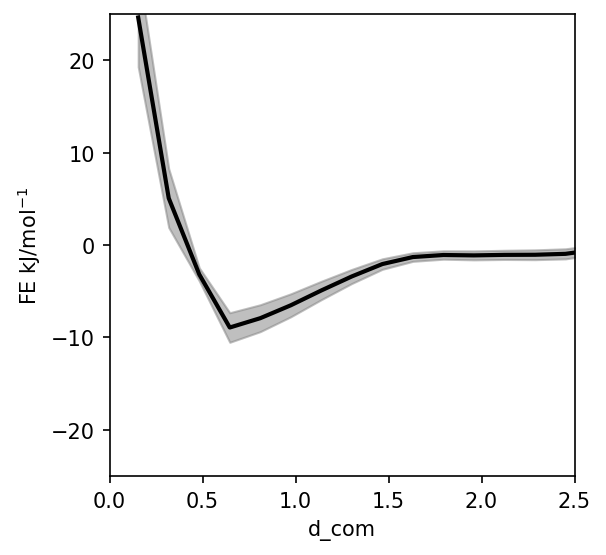

In [22]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 4))
data, ax = block_anal(colvars.dcom, colvars.weights, ax, True, folds=5, nbins=20)
ax.set_ylabel(r"FE kJ/mol$^{-1}$")
ax.set_xlabel("d_com")
ax.set_xlim(0, d_cutoff)
ax.set_ylim(-25, 25)
plt.show()

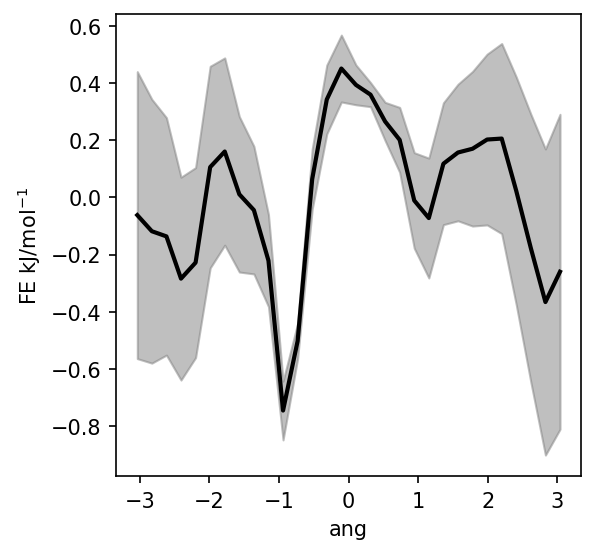

In [23]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 4))
data, ax = block_anal(colvars.ang, colvars.weights, ax, False, folds=5, nbins=30)
ax.set_ylabel(r"FE kJ/mol$^{-1}$")
ax.set_xlabel("ang")
plt.show()

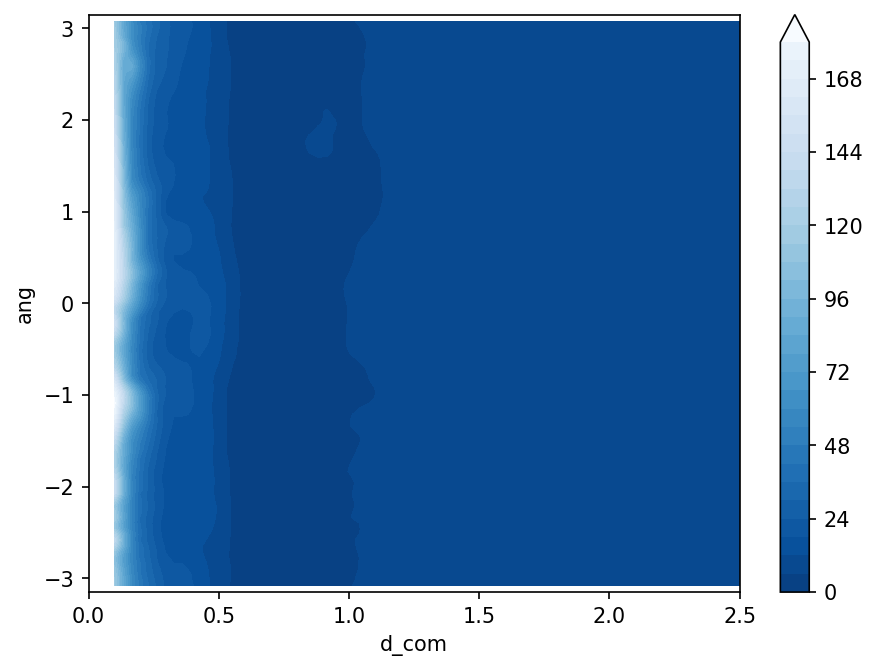

In [24]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(7, 5))
ax, CS = FE_plot(colvars.dcom, colvars.ang, colvars.weights, ax, fig)
cb = fig.colorbar(CS)
ax.set_ylabel("ang")
ax.set_xlabel("d_com")
ax.set_xlim(0.0, d_cutoff)
ax.set_ylim(-3.15, 3.15)
plt.show()

In [25]:
FE_val = calc_FE_2d(colvars.dcom, colvars.ang, colvars.weights, {"X": (0.5, 1.5), "Y": (-np.pi, np.pi)}, {"X": (2.0, 2.5), "Y": (-np.pi, np.pi)})
print (f"Free energy diff = {FE_val:.3f} kJ/Mol")

Free energy diff = 7.515 kJ/Mol


In [26]:
analysis_data = colvars[(colvars.dcom > 0.2) & (colvars.dcom < 2.5)]
block_anal_data = block_anal_2d(analysis_data.dcom, analysis_data.ang, analysis_data.weights, nbins=50, folds=25)

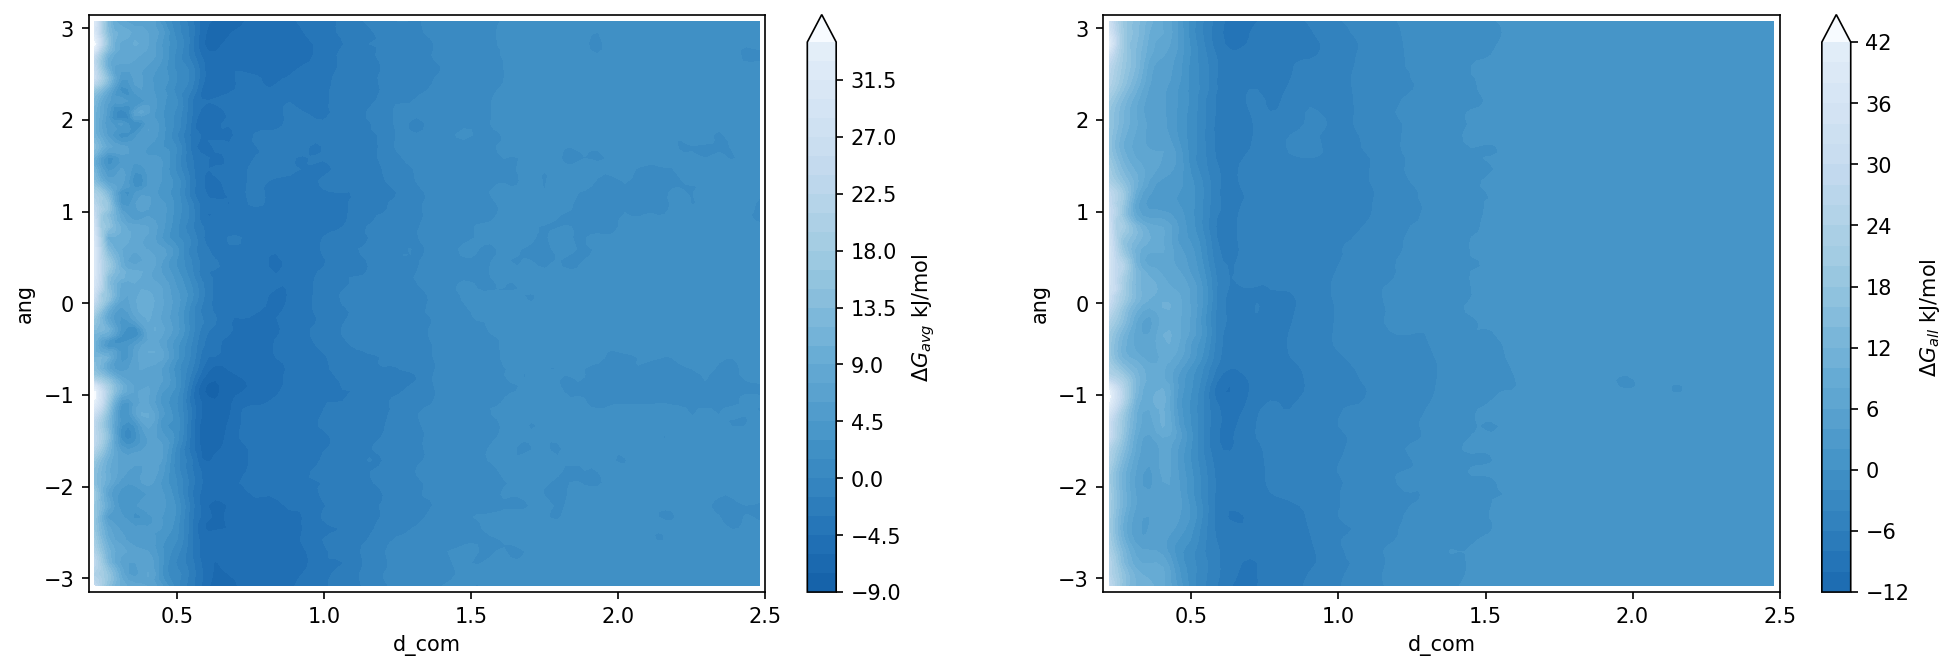

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=150)
ax[0], CS = FE_plot_nocalc(block_anal_data.x, block_anal_data.y, block_anal_data.f_avg, ax[0])
cb = fig.colorbar(CS)
cb.set_label(r"$\Delta G_{avg}$ kJ/mol")
ax[0].set_ylabel("ang")
ax[0].set_xlabel("d_com")
ax[0].set_xlim(0.2, d_cutoff)
ax[0].set_ylim(-3.15, 3.15)
ax[1], CS = FE_plot_nocalc(block_anal_data.x, block_anal_data.y, block_anal_data.f_all, ax[1])
cb = fig.colorbar(CS)
ax[1].set_ylabel("ang")
ax[1].set_xlabel("d_com")
ax[1].set_xlim(0.2, d_cutoff)
ax[1].set_ylim(-3.15, 3.15)
cb.set_label(r"$\Delta G_{all}$ kJ/mol")


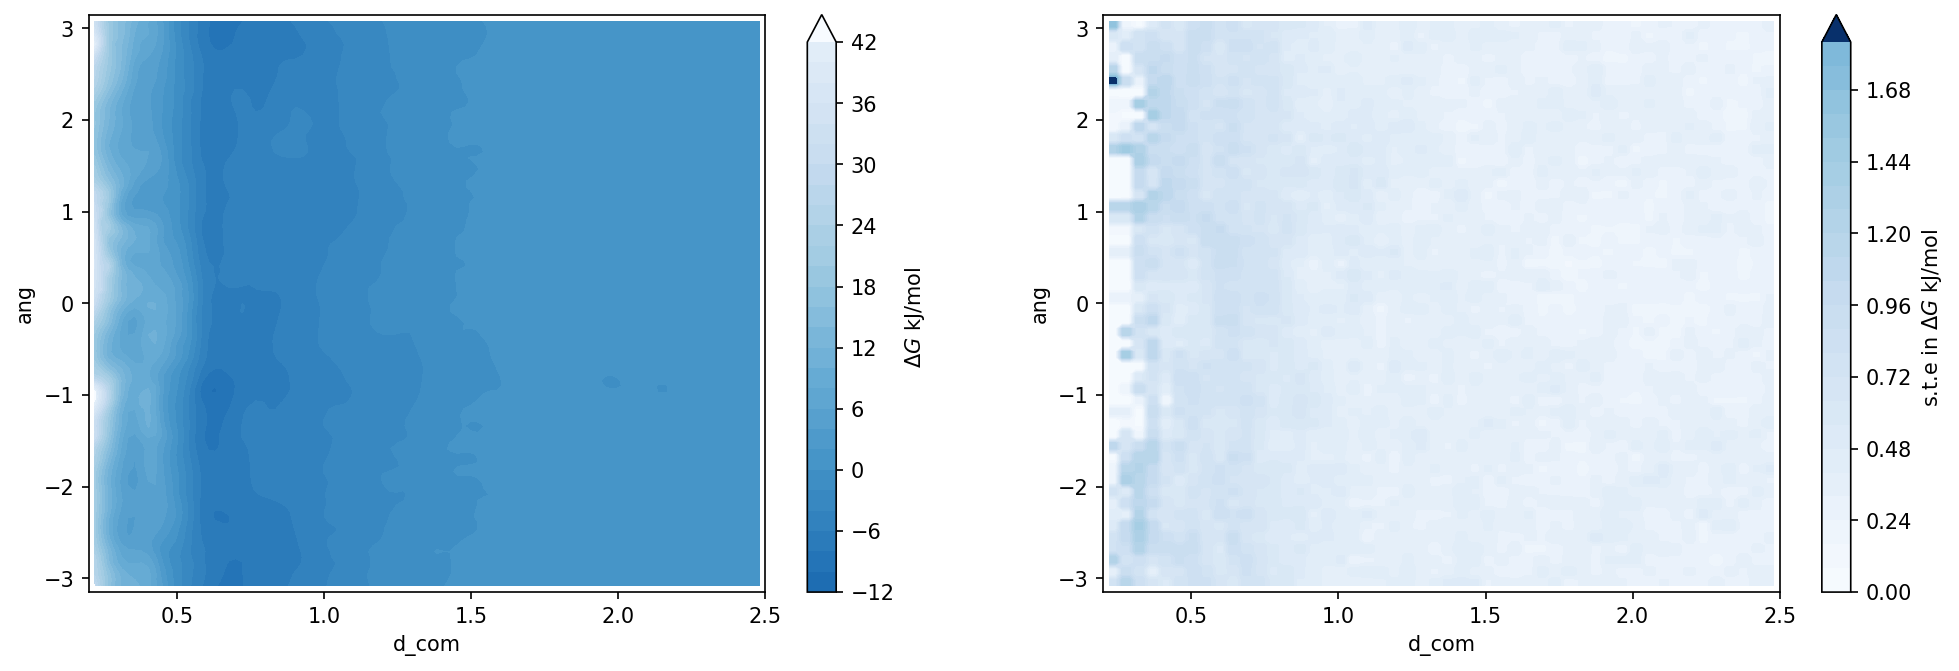

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=150)
ax[0], CS = FE_plot_nocalc(block_anal_data.x, block_anal_data.y, block_anal_data.f_all, ax[0])
cb = fig.colorbar(CS)
cb.set_label(r"$\Delta G$ kJ/mol")
ax[0].set_ylabel("ang")
ax[0].set_xlabel("d_com")
ax[0].set_xlim(0.2, d_cutoff)
ax[0].set_ylim(-3.15, 3.15)
ax[1], CS = FE_plot_nocalc(block_anal_data.x, block_anal_data.y, block_anal_data.ste, ax[1], cb_min=0, cb_max=4, method='nearest', cmap=plt.cm.Blues)
cb = fig.colorbar(CS)
ax[1].set_ylabel("ang")
ax[1].set_xlabel("d_com")
ax[1].set_xlim(0.2, d_cutoff)
ax[1].set_ylim(-3.15, 3.15)
cb.set_label(r"s.t.e in $\Delta G$ kJ/mol")


In [29]:
bound_data = block_anal_data[(block_anal_data.x>0.5) & (block_anal_data.x<1.5)][['x', 'y', 'f_all', 'ste']]
bound_data.rename(columns={'f_all': 'F'}, inplace=True)
r_err = calc_region_error(bound_data.copy())
r_int = calc_region_int(bound_data.copy())
print(r_int, r_err)

-9.215515728294195 0.020968136606440566


In [30]:
unbound_data = block_anal_data[(block_anal_data.x>2.0) & (block_anal_data.x<2.5)][['x', 'y', 'f_all', 'ste']]
unbound_data.rename(columns={'f_all': 'F'}, inplace=True)
p_err = calc_region_error(unbound_data.copy())
p_int = calc_region_int(unbound_data.copy())
print(p_int, p_err)

-1.7284321043792659 0.0138109254328739


In [31]:
bound_data = block_anal_data[(block_anal_data.x>0.5) & (block_anal_data.x<1.5)][['x', 'y', 'f_avg', 'ste']]
bound_data.rename(columns={'f_avg': 'F'}, inplace=True)
r_err = calc_region_error(bound_data.copy())
r_int = calc_region_int(bound_data.copy())
print(r_int, r_err)

-7.656728271346174 0.018997867174568604


In [32]:
unbound_data = block_anal_data[(block_anal_data.x>2.0) & (block_anal_data.x<2.5)][['x', 'y', 'f_avg', 'ste']]
unbound_data.rename(columns={'f_avg': 'F'}, inplace=True)
p_err = calc_region_error(unbound_data.copy())
p_int = calc_region_int(unbound_data.copy())
print(p_int, p_err)

-0.7738625706140693 0.013534836045381422
